In [4]:
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import skimage

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf

import sklearn
import sklearn.metrics
import sklearn.neighbors
import sklearn.ensemble
from sklearn.metrics import roc_curve, auc

from tqdm.notebook import tqdm

import pims
import skimage
import skimage.morphology
import ipywidgets as iw

import matplotlib.animation as animation
from IPython import display

from skimage.color import gray2rgb
import cv2


print(f"tf version: {tf.__version__}", f", keras version: {keras.__version__}")

ddir = pathlib.Path("data")
print(f"We expect the data files in directory {ddir.absolute()}")

tf version: 2.15.0 , keras version: 2.15.0
We expect the data files in directory d:\Library\Downloads\Documents\School\SUPSI_23-24\deep_learning\notebooks\data


In [2]:
def read_image(name, set_="train_val", im_type="images"):
    im = skimage.io.imread(pathlib.Path(ddir, set_, im_type, name))
    if im_type == "masks":
        return skimage.img_as_float(im)
    return im

def get_images(set_="train_val", im_type="images"):
    return [read_image(file.name, set_, im_type) 
            for file in pathlib.Path(ddir, set_, im_type).iterdir() 
            if file.is_file()]
    
def get_filenames(set_="train_val", im_type="images"):
    return [file.name[:-4]
            for file in pathlib.Path(ddir, set_, im_type).iterdir() 
            if file.is_file()]

# patches

In [13]:
patches_train = np.load(pathlib.Path(ddir, "npy", "patches_train.npy"))
labels_train = np.load(pathlib.Path(ddir, "npy", "labels_train.npy"))
patches_test = np.load(pathlib.Path(ddir, "npy", "patches_test.npy"))
labels_test = np.load(pathlib.Path(ddir, "npy", "labels_test.npy"))
print(len(patches_train), len(labels_train), len(patches_test), len(labels_test))

37093 37093 2828 2828


In [28]:
patches_train_reduced = np.load(pathlib.Path(ddir, "npy", "patches_train_reduced.npy"))
labels_train_reduced = np.load(pathlib.Path(ddir, "npy", "labels_train_reduced.npy"))
patches_test_reduced = np.load(pathlib.Path(ddir, "npy", "patches_test_reduced.npy"))
labels_test_reduced = np.load(pathlib.Path(ddir, "npy", "labels_test_reduced.npy"))
print(len(patches_train_reduced), len(labels_train_reduced), len(patches_test_reduced), len(labels_test_reduced))

37128 37128 2763 2763


# random forest

In [14]:
def plot_AUC(labels_test,labels_prob,title="",figsize=(4,4)):
    if isinstance(labels_prob,dict):
        fprs = []
        tprs = []
        roc_aucs = []
        for key in labels_prob.keys():
            fpr, tpr, _ = roc_curve(labels_test, labels_prob[key])
            roc_auc = auc(fpr, tpr)
            fprs.append(fpr)
            tprs.append(tpr)
            roc_aucs.append(roc_auc)
    else:
        fpr, tpr, _ = roc_curve(labels_test, labels_prob)
        roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=figsize)
    if isinstance(labels_prob,dict):
        for i in range(len(fprs)):
            plt.plot(fprs[i], tprs[i], lw=2, label=f'{list(labels_prob.keys())[i]} (AUC = {round(roc_aucs[i],2)})')
    else:
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve '+title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return roc_auc
    
    
def plot_confustion_matrix(labels_test, labels_pred,percent=False):
    acc = np.mean(labels_test == labels_pred)
    if percent:
        cm = sklearn.metrics.confusion_matrix(y_true=labels_test, y_pred=labels_pred,normalize="true")
        fmt = '.0%'
    else:
        cm = sklearn.metrics.confusion_matrix(y_true=labels_test, y_pred=labels_pred)
        fmt = 'd'
    sns.heatmap(cm, annot=True, xticklabels=["Fish", "Not fish"], yticklabels=["Fish", "Not fish"], fmt=fmt)
    plt.xlabel('Prediction', fontsize = 12) 
    plt.ylabel('Truth', fontsize = 12) 
    plt.title(f"Confusion Matrix testing instances (acc={acc:.0%})", fontsize = 15)
    return cm

In [15]:
def extract_features(im):
    size = 10
    center = np.array(im.shape[:2])//2
    return np.array([im[center[0]-size//2:center[0]+size//2,center[1]-size//2:center[1]+size//2,:]]).flatten()

def learn():
    features_train = []
    for im in patches_train:
        features_train.append(extract_features(im.astype(float)/255))
    features_train = np.array(features_train)

    features_test = []
    for im in patches_test:
        features_test.append(extract_features(im.astype(float)/255))
    features_test = np.array(features_test)

    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=20)
    clf.fit(features_train, labels_train)
    labels_pred = clf.predict(features_test)
    labels_prob = np.array(clf.predict_proba(features_test))[:,1]
    
    fpr, tpr, _ = roc_curve(labels_test, labels_prob)
    roc_auc = auc(fpr, tpr)
    
    print(f"Accuracy: {sklearn.metrics.accuracy_score(labels_test, labels_pred)}")
    print(f"AUC: ",roc_auc)
  
    return labels_pred,labels_prob,clf


In [31]:
print(f"RF:")
labels_pred_rf, labels_prob_rf,clf_rf = learn()

RF:
Accuracy: 0.7075671852899575
AUC:  0.796854231723917


# load models

## regular

In [32]:
# simple NN
model_nn = keras.models.load_model(pathlib.Path(ddir, "models", "model_nn.keras"))
model_nn_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_nn_aug.keras"))


# assignment example
model_cnn1 = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn1.keras"))
model_cnn1_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn1_aug.keras"))


# RPS example
model_cnn2 = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn2.keras"))
model_cnn2_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn2_aug.keras"))

model_cnn2_2 = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn2_2.keras"))
# model_cnn2_2_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn2_2_aug.keras"))

# Ours
model_cnn3 = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn3.keras"))
model_cnn3_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn3_aug.keras"))

## reduced

In [5]:
# simple NN
model_nn_red = keras.models.load_model(pathlib.Path(ddir, "models", "model_nn_red.keras"))
model_nn_red_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_nn_red_aug.keras"))


# assignment example
model_cnn1_red = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn1_red.keras"))
model_cnn1_red_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn1_red_aug.keras"))


# RPS example
model_cnn2_red = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn2_red.keras"))
model_cnn2_red_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn2_red_aug.keras"))

model_cnn2_2_red = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn2_2_red.keras"))
model_cnn2_2_red_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn2_2_red_aug.keras"))

# Ours
model_cnn3_red = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn3_red.keras"))
model_cnn3_red_aug = keras.models.load_model(pathlib.Path(ddir, "models", "model_cnn3_red_aug.keras"))

OSError: No file or directory found at data\models\model_nn_red.keras

In [45]:
model_simple = keras.models.load_model(pathlib.Path(ddir, "models", "model_full_simple.keras"))
history_simple = np.load(pathlib.Path(ddir, "models", "model_full_simple_history.npy"), allow_pickle=True).item()

model_unet = keras.models.load_model(pathlib.Path(ddir, "models", "model_full_unet.keras"))
history_unet = np.load(pathlib.Path(ddir, "models", "model_full_unet_history.npy"), allow_pickle=True).item()

model_simple_red = keras.models.load_model(pathlib.Path(ddir, "models", "model_full_simple_red.keras"))
history_simple_red = np.load(pathlib.Path(ddir, "models", "model_full_simple_red_history.npy"), allow_pickle=True).item()

model_unet_red = keras.models.load_model(pathlib.Path(ddir, "models", "model_full_unet_red.keras"))
history_unet_red = np.load(pathlib.Path(ddir, "models", "model_full_unet_red_history.npy"), allow_pickle=True).item()

In [35]:
best_roc_auc = 0
models = list(pathlib.Path(ddir, "models","checkpoints").glob("*nn*.keras"))
models.extend(pathlib.Path(ddir, "models").glob("*nn*.keras"))
for checkpoint in models:
    if "red" in checkpoint.name:
        test_set = patches_test_reduced
        test_labels = labels_test_reduced
    else:
        test_set = patches_test
        test_labels = labels_test
    print("---",checkpoint.name)
    model = keras.models.load_model(checkpoint)
    labels_proba = model.predict(test_set.astype(float)/255, verbose=0)
    labels_pred = labels_proba > 0.5
    fpr, tpr, _ = roc_curve(test_labels, labels_proba)
    roc_auc = auc(fpr, tpr)
    
    print(f"Accuracy: {sklearn.metrics.accuracy_score(test_labels, labels_pred):.4f}%")
    print(f"AUC: {roc_auc:.4f}")
    
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_checkpoint = checkpoint
        best = model
        
print(f"Best checkpoint: {best_checkpoint.name}")

--- checkpoint_best_model_cnn1_2023-12-01_01-49-06.keras
Accuracy: 0.7733%
AUC: 0.8510
--- checkpoint_best_model_cnn1_aug_2023-12-01_02-50-18.keras
Accuracy: 0.7443%
AUC: 0.8354
--- checkpoint_best_model_cnn1_red_2023-12-07_01-23-47.keras
Accuracy: 0.7163%
AUC: 0.8024
--- checkpoint_best_model_cnn1_red_2023-12-08_16-35-11.keras
Accuracy: 0.7213%
AUC: 0.8002
--- checkpoint_best_model_cnn1_red_2023-12-08_21-39-57.keras
Accuracy: 0.7781%
AUC: 0.8707
--- checkpoint_best_model_cnn1_red_aug_2023-12-07_01-34-02.keras
Accuracy: 0.7680%
AUC: 0.8549
--- checkpoint_best_model_cnn1_red_aug_2023-12-08_16-46-32.keras
Accuracy: 0.4995%
AUC: 0.4526
--- checkpoint_best_model_cnn1_red_aug_2023-12-08_21-54-14.keras
Accuracy: 0.4995%
AUC: 0.3929
--- checkpoint_best_model_cnn1_red_aug_2023-12-09_02-47-22.keras
Accuracy: 0.4872%
AUC: 0.4636
--- checkpoint_best_model_cnn2_2023-12-01_01-55-46.keras
Accuracy: 0.7903%
AUC: 0.8686
--- checkpoint_best_model_cnn2_2023-12-01_12-13-59.keras
Accuracy: 0.7652%
AUC: 0.

# create masks

In [21]:
def create_mask(image,stride=4,batch_size=64,type_="NN",model=None,red=False):
    patch_size = (50, 50)
    ignore = int(patch_size[0]/2)
    image = image.astype(float) / 255
    
    if red:
        image = skimage.transform.resize(image, (int(image.shape[0]//2), int(image.shape[1]//2),3))
    height, width = image.shape[:2]
    segmentation_mask = np.ones((height, width), dtype=np.float32)

#     patches = np.lib.stride_tricks.sliding_window_view(image, (patch_size[0], patch_size[1],3),axis=(0,1,2))
#     patches = patches[::stride, ::stride, :, :].reshape(-1, patch_size[0], patch_size[1], 3)
    patches = []
    # for y in range(0, height - patch_size[0] + 1, stride):
    #     for x in range(0, width - patch_size[1] + 1, stride):
    for y in range(ignore, height - patch_size[0] + ignore, stride):
        for x in range(ignore, width - patch_size[1] + ignore, stride):
            # patch = image[y:y + patch_size[0], x:x + patch_size[1]]
            patch = image[y-ignore:y+ignore, x-ignore:x + ignore]
            patches.append(patch)
    patches = np.array(patches) 


    if type_ == "NN" and model is not None:
        # predictions = model.predict(patches, batch_size=batch_size)[:,1]
        predictions = np.array(model.predict(patches, batch_size=batch_size))
    elif type_ == "RF" and clf_rf is not None:  
        patches_feat = []
        for patch in patches:
            patches_feat.append(extract_features(patch))
        patches_feat = np.array(patches_feat) 
        predictions = np.array(clf_rf.predict_proba(patches_feat))[:,1]
    else:
        raise ValueError("No model provided")
    
    index = 0
    for y in range(ignore, height - patch_size[0] + ignore, stride):
        for x in range(ignore, width - patch_size[1] + ignore, stride):
            pred_fish = predictions[index]
            if stride == 1:
                segmentation_mask[y,x] = pred_fish
            elif stride % 2 == 0:
                y1, y2 = y - stride // 2, y + stride // 2
                x1, x2 = x - stride // 2, x + stride // 2
                segmentation_mask[y1:y2,x1:x2] = pred_fish
            else:
                y1, y2 = y - stride // 2, y + stride // 2 + 1
                x1, x2 = x - stride // 2, x + stride // 2 + 1
                segmentation_mask[y1:y2,x1:x2] = pred_fish
            index += 1
    return segmentation_mask

images:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 299ms/step


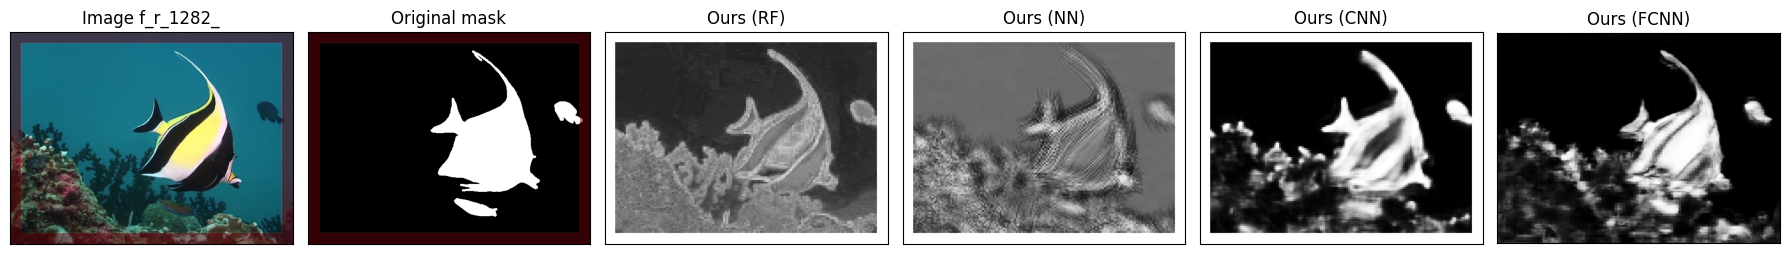

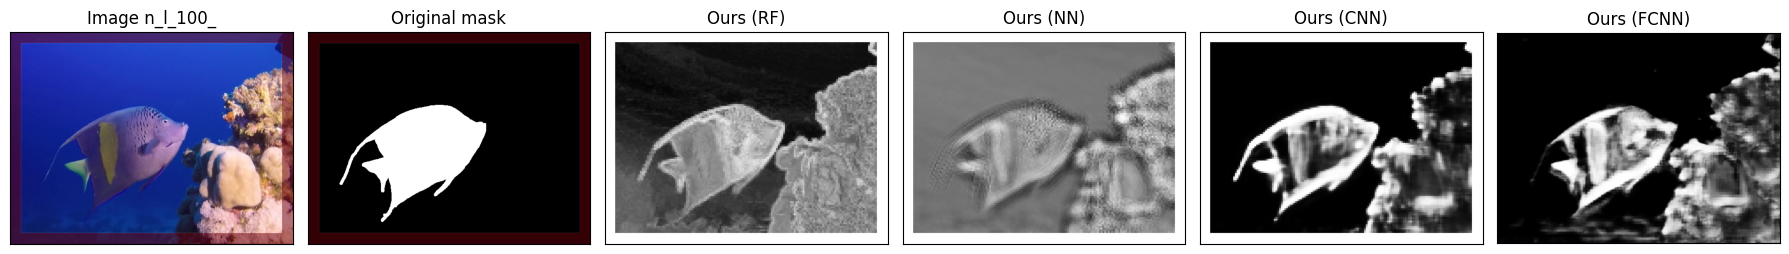

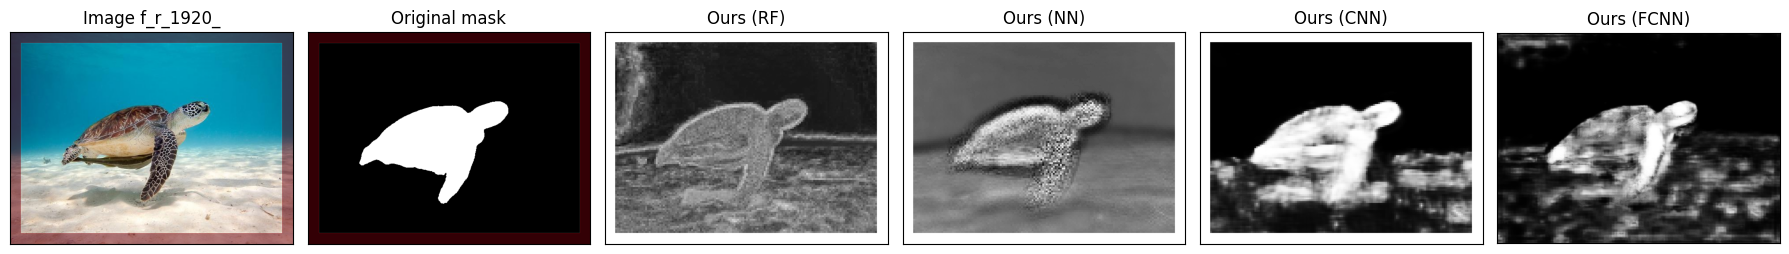

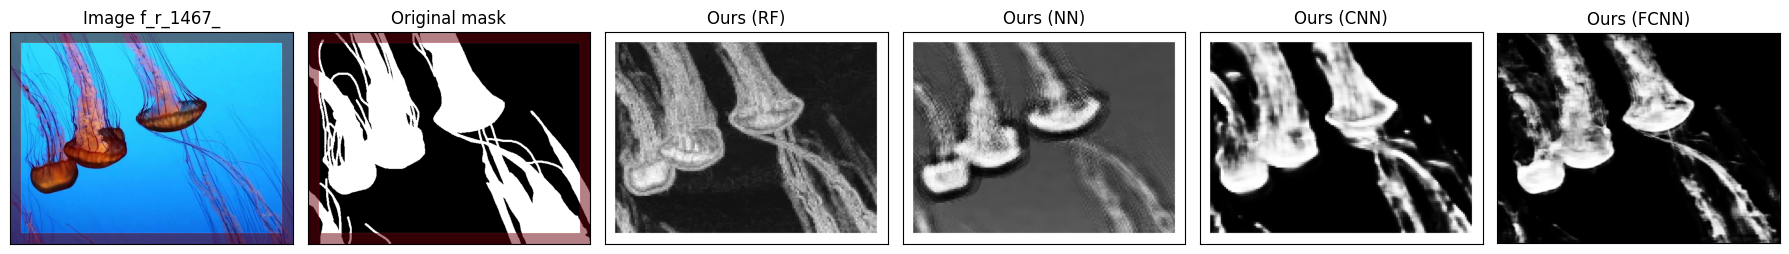

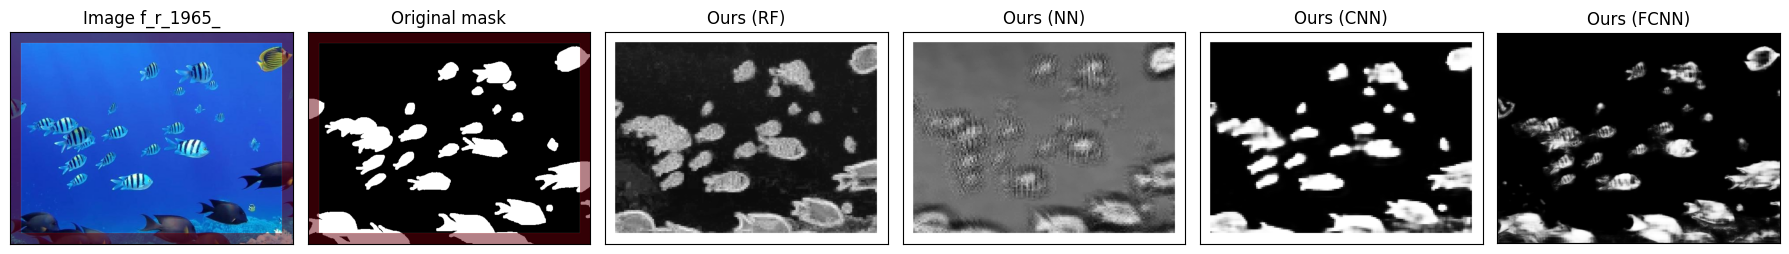

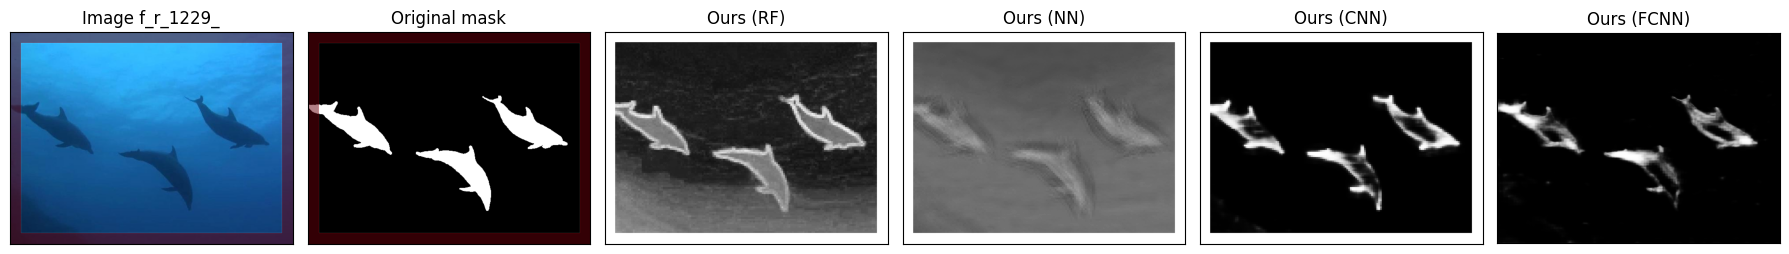

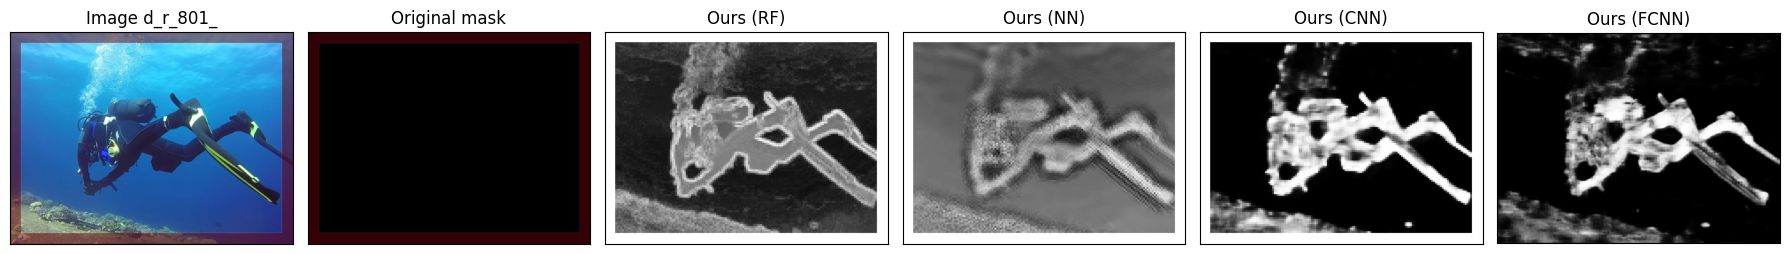

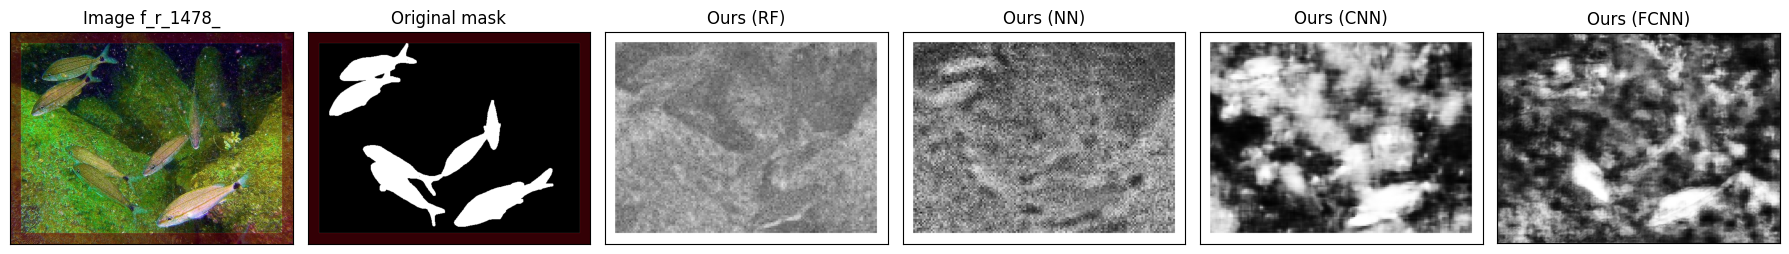

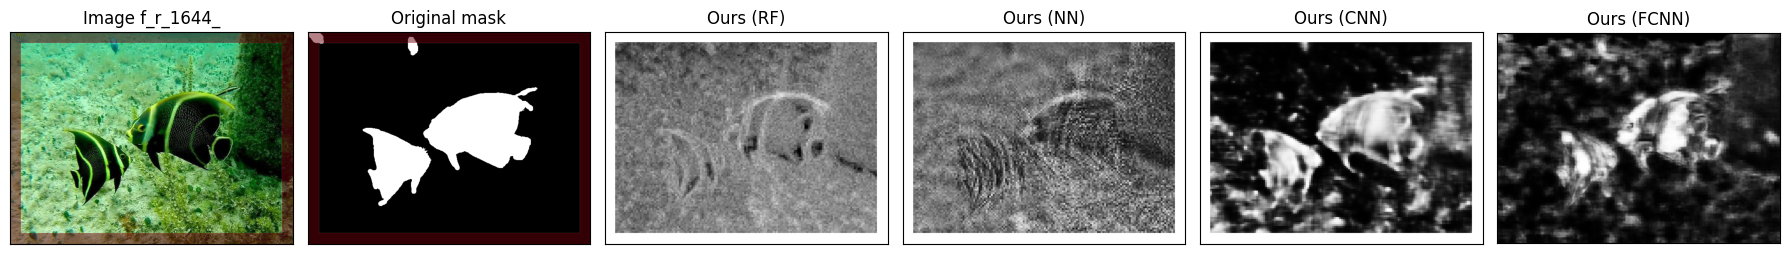

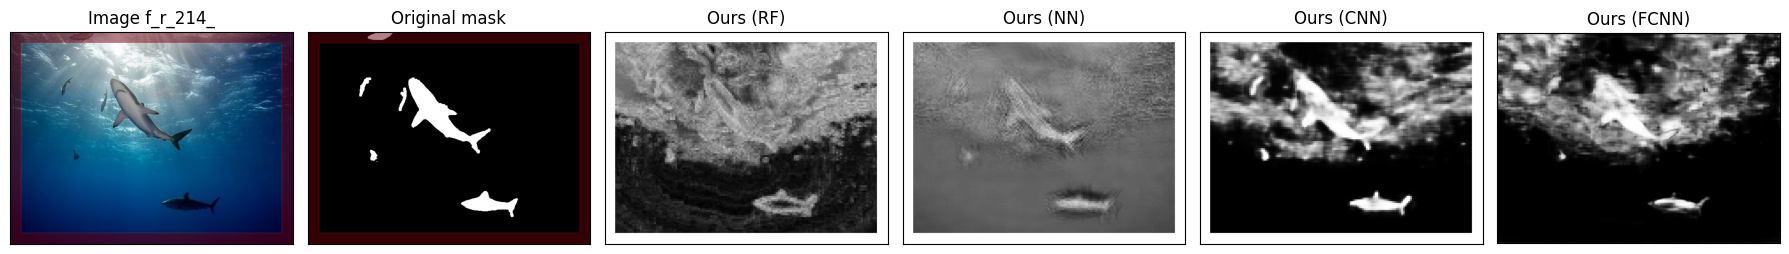

In [59]:
ims = [ 
        "f_r_1282_",
        "n_l_100_",
        "f_r_1920_",
        "f_r_1467_",
        "f_r_1965_",
        "f_r_1229_",
        "d_r_801_",
        "f_r_1478_",
        "f_r_1644_",
        "f_r_214_"
        ]

ignore  = 25
frame = np.zeros((480,640))
frame[:ignore,:] = 1
frame[:,:ignore] = 1
frame[-ignore:,:] = 1
frame[:,-ignore:] = 1

for im in tqdm(ims,desc="images"):
    test_im = read_image(im + '.jpg', im_type="images", set_="test")
    test_mask = read_image(im + '.bmp', im_type="masks", set_="test")
    segmentation_mask_rf = create_mask(test_im,stride=4,batch_size=512,type_="RF")
    segmentation_mask_nn = create_mask(test_im,stride=4,batch_size=512,type_="NN",model=  model_nn_red)
    segmentation_mask_best = create_mask(test_im,stride=4,batch_size=512,type_="NN",model=  best)
    segmentation_mask_fcnn = model_unet_red.predict(np.array( [(test_im.astype(float) / 255)[2:-2,1:-1],]))[0]
    
    fig, axes = plt.subplots(1,6,figsize=(18,5))
    axes[0].imshow(test_im)
    axes[0].imshow(frame ,alpha=0.5*(frame>0),cmap="Reds")
    axes[1].imshow(np.all(test_mask == (1, 1, 0), axis=-1), cmap="gray", vmin=0, vmax=1)
    axes[1].imshow(frame ,alpha=0.5*(frame>0),cmap="Reds")
    axes[2].imshow(segmentation_mask_rf , cmap="gray", vmin=0, vmax=1)
    axes[3].imshow(segmentation_mask_nn , cmap="gray", vmin=0, vmax=1)
    axes[4].imshow(segmentation_mask_best, cmap="gray", vmin=0, vmax=1)
    axes[5].imshow(segmentation_mask_fcnn, cmap="gray", vmin=0, vmax=1)
    
    axes[0].set_title(f"Image {im}")
    axes[1].set_title("Original mask")
    axes[2].set_title("Ours (RF)")
    axes[3].set_title("Ours (NN)")
    axes[4].set_title("Ours (CNN)")
    axes[5].set_title("Ours (FCNN)")
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

# Testing on video fragments

In [2]:
#model_cnn2_2_red = keras.models.load_model(pathlib.Path(ddir, "models", "checkpoint_best_model_cnn2_2_red_2023-12-08_23-56-25.keras"))
model_fcnn = keras.models.load_model(pathlib.Path(ddir, "models", "model_full_unet_red.keras"))
model_best = keras.models.load_model(pathlib.Path(ddir, "models", "checkpoint_best_model_full_unet_red2_2023-12-14_11-34-55.keras"))
model_fcnn_final = keras.models.load_model(pathlib.Path(ddir, "models", "model_full_unet_red_final.keras"))

In [8]:
def process_and_save_video(list_videos, model_fcnn, save_directory, frame_size, padding,title):
    for j, video in enumerate(list_videos, start=1):
        print(len(video))
        print(video[0].shape)
        ims = []
        for i in tqdm(range(0, len(video), 10)):
            ims.append(skimage.transform.downscale_local_mean(
                skimage.img_as_float(np.asarray(video[i])), (2, 2, 1)))
        ims = np.array(ims)

        ignore = 25
        frame = np.zeros(frame_size)
        frame[:ignore, :] = 1
        frame[:, :ignore] = 1
        frame[-ignore:, :] = 1
        frame[:, -ignore:] = 1

        # fig, axes = plt.subplots(len(ims), 3, figsize=(16, 16))

        for i, im in enumerate(ims):
            im = skimage.img_as_float(im)
            segmentation_mask_fcnn = model_fcnn.predict(im[padding[0]:padding[1], padding[2]:padding[3]][np.newaxis, :])[0]
            # axes[i, 0].imshow(im)
            # axes[i, 1].imshow(segmentation_mask_fcnn, cmap="gray", vmin=0, vmax=1)
            binary_mask = segmentation_mask_fcnn[:, :, 0] > 0.5
            # axes[i, 2].imshow(binary_mask, vmin=0, vmax=1)

            # axes[i, 0].set_title(f"Image")
            # axes[i, 1].set_title("Ours (CNN)")
            # axes[i, 2].set_title("Mask")
            # for ax in axes.flatten():
            #     ax.set_xticks([])
            #     ax.set_yticks([])
            # fig.tight_layout()

            segmentation_mask_fcnn = gray2rgb(segmentation_mask_fcnn.squeeze())
            binary_mask = gray2rgb(binary_mask.squeeze())

            im = skimage.transform.resize(im, segmentation_mask_fcnn.shape)
            stack = np.hstack([im, segmentation_mask_fcnn, binary_mask])
            save_path = save_directory / f"{title}{j}"
            save_path.mkdir(exist_ok=True)
            plt.imsave(save_path / f'frame{i}.png', stack)

        video_name = f'{title}{j}.mp4'

        images = [img for img in os.listdir(save_path) if img.endswith(".png")]
        frame = cv2.imread(os.path.join(save_path, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(os.path.join(save_directory, video_name), 0, 1, (width, height))

        for image in images:
            video.write(cv2.imread(os.path.join(save_path, image)))

        cv2.destroyAllWindows()
        video.release()


In [17]:
# Example usage
list_videos = [
    pims.Video(ddir/"TEST"/"videos"/"test_video_fish_1.mp4"),
    pims.Video(ddir/"TEST"/"videos"/"test_video_fish_2.mp4"),
    pims.Video(ddir/"TEST"/"videos"/"test_video_fish_3.mp4"),
    pims.Video(ddir/"TEST"/"videos"/"test_video_fish_4.mp4"),
    pims.Video(ddir/"TEST"/"videos"/"test_video_fish_bern_1.mov"),
    pims.Video(ddir/"TEST"/"videos"/"test_video_fish_bern_2.mov"),
    pims.Video(ddir/"TEST"/"videos"/"test_video_fish_kais_2.mp4")
]

save_directory = ddir / "TEST" / "videos"
process_and_save_video(list_videos[3:4], model_best, save_directory, frame_size=(480, 854),padding=(2, -2, 2, -5),title="prediction_video_fish_4")
process_and_save_video(list_videos[4:6], model_best, save_directory, frame_size=(360, 640),padding=(2, -2, 2, -4),title="prediction_video_fish_bern")
process_and_save_video(list_videos[6:], model_best, save_directory, frame_size=(480, 852),padding=(2, -2, 2, -2),title="prediction_video_fish_kais")

147
(480, 852, 3)


  0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 106ms/step
